## Import libraries

In [1]:
import numpy as np # for processing of arrays
import pandas as pd
import sklearn # to display model performance on test set
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt # to display images from dataset
import os
from glob import glob
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

# import tensorflow backend and keras api
import tensorflow as tf
import keras
import keras.backend as K

# import model layers and InceptionV3 architecture
from tensorflow.python.keras.models import Model
from sklearn.ensemble import RandomForestClassifier

# import optimizers and callbacks
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

from tensorflow.python.keras.layers import VersionAwareLayers

layers = VersionAwareLayers()
Dropout = layers.Dropout
Dense = layers.Dense
Input = layers.Input
concatenate = layers.concatenate
GlobalAveragePooling2D = layers.GlobalAveragePooling2D
AveragePooling2D = layers.AveragePooling2D
Flatten = layers.Flatten

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check if CUDA is available
CUDA is a parallel computing platform which can speed up our computations (i.e. train this model much faster!) and can be used on any Nvidia GPU from the G8x series onwards.

If CUDA is unavailable, check that your runtime has been changed to GPU. (Runtime -> Change runtime type -> GPU)

In [2]:
print("GPU:", tf.config.list_physical_devices('GPU'), "\nCUDA Enabled:", tf.test.is_built_with_cuda(), "\nGPU Name:", tf.test.gpu_device_name(), "\nVisible Devices:", tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

GPU: [] 
CUDA Enabled: True 
GPU Name:  
Visible Devices: []
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12307316906286108173
]


## Download dataset

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!unzip gdrive/MyDrive/ff.zip

Streaming output truncated to the last 5000 lines.
  inflating: val/fake_image/00044/00619.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00619.jpg  
  inflating: val/fake_image/00044/00180.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00180.jpg  
  inflating: val/fake_image/00044/00154.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00154.jpg  
  inflating: val/fake_image/00044/00800.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00800.jpg  
  inflating: val/fake_image/00044/00206.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00206.jpg  
  inflating: val/fake_image/00044/00826.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00826.jpg  
  inflating: val/fake_image/00044/00749.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00749.jpg  
  inflating: val/fake_image/00044/00774.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00774.jpg  
  inflating: val/fake_image/00044/00413.jpg  
  inflating: __MACOSX/val/fake_image/00044/._00413.jpg  
  inflating: val/fake_

In [3]:
# ImageDataGenerator loads images into memory in batches of specified size (in this case 16 images per batch)
# this avoids possible memory issues
train_folder = 'ff/train'
val_folder = 'ff/val'
df_train = pd.read_csv(train_folder + '/image_labels.csv')
df_val = pd.read_csv(val_folder + '/image_labels.csv')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True, vertical_flip=True, width_shift_range=0.10, rotation_range=0.2) # rescaling normalizes pixel values from the range [0,255] to [0,1]
train_set = datagen.flow_from_dataframe(dataframe=df_train, directory=train_folder, classes= ['real', 'fake'], class_mode="categorical", target_size=(299, 299), batch_size=32)
val_set = datagen.flow_from_dataframe(dataframe=df_val, directory=val_folder, classes= ['real', 'fake'], class_mode="categorical", target_size=(299, 299), batch_size=32)

print("Check class name mapping to label index:")
print(train_set.class_indices)
print(val_set.class_indices)

Found 66722 validated image filenames belonging to 2 classes.
Found 12592 validated image filenames belonging to 2 classes.
Check class name mapping to label index:
{'fake': 0, 'real': 1}
{'fake': 0, 'real': 1}


## Model architecture

In [4]:
from tensorflow.keras.applications.xception import Xception

In [5]:
base_model1 = Xception(include_top=False, weights="imagenet", input_tensor=Input(shape=(299,299,3)))
layer1 = GlobalAveragePooling2D()(base_model1.output)

layer1 = Dense(2, activation="softmax", name="output")(layer1)
input_layer = base_model1.input
model1 = Model(inputs=input_layer, outputs=layer1, name="Xception")


In [7]:
# display model summary
model1.summary()

Model: "Xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

<a name="Optimisers"></a>
### Optimiser
> Updates model in response to output of loss function (loss function tells the model the error in classification of individual samples)

In [6]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001, amsgrad=True)

In [7]:
# optimisers from Keras https://keras.io/api/optimizers/#available-optimizers

#compile model
model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

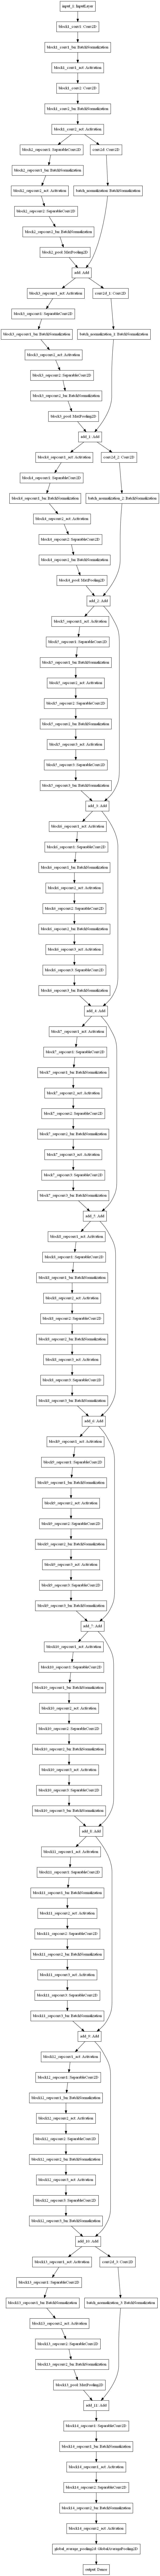

In [10]:
plot_model(model1, to_file='model.png')

## Define callbacks

In [45]:
!mkdir "weights"

In [11]:
# ModelCheckpoint callback saves the model weights after every epoch (iteration through the dataset)
# if the validation accuracy is higher than that of the model previously saved
checkpoint = ModelCheckpoint("/content/weights/xception.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

## Train model
> Fit the model to the data

In [ ]:
hist = model1.fit(train_set, steps_per_epoch=64, epochs = 65, validation_data=val_set, validation_steps=64, callbacks = [checkpoint])

Epoch 1/65
 1/64 [..............................] - ETA: 1:29:45 - loss: 0.8191 - accuracy: 0.2812

## Display model training/validation accuracy and loss

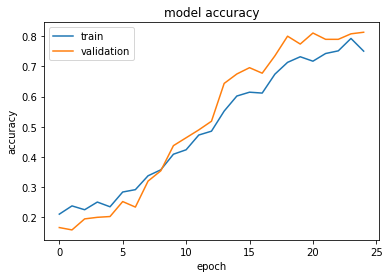

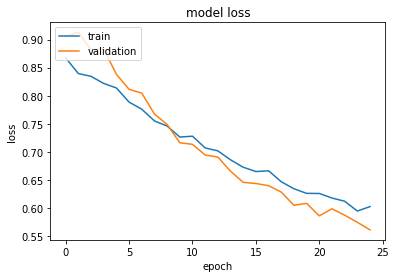

In [50]:
# plot training and validation accuracy against epochs using matplotlib
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss against epochs using matplotlib
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Load Weights

In [8]:
model1.load_weights("xception.h5")

<a name="eval"></a>
## Evaluate Model

To classify the video as real or fake, we will first obtain the model's predictions on each frame extracted from the video. We then take the mean of the prediction (probability) of the frames as the prediction of the video. 

In [9]:
def read_image_from_disk(path):

  """
  Helper function to read image from disk given a absolute path.

  :param path: Absolute path to image file on disk
  :return: Image in Numpy Ndarray representation
  """

  img = tf.keras.preprocessing.image.load_img(path, target_size=(299,299,3))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = img/255
  img = np.expand_dims(img, axis=0)

  return img


def get_frames_to_vid_mapping(frame_list):

  """
  Helper function to generate a mapping of frames to it's corresponding video 
  name.

  The path of frames in the frame_list will be in such format:
  image/[video name]/[frame number].jpg
  e.g. image/00000/00032.jpg

  :param frame_list: A list of paths to the image frames
  :return: A sorted dictionary with keys as the video name and value as the
           corresponding frames.
           e.g. of returned mapping dictionary:

            {
              "00000":[
                  "00032",
                  "00064",
                  .
                  .
                  .
                  "00487"
              ],
              "00001":[
                  "00000",
                  "00032",
                  .
                  .
                  .
                  "00392"
              ],
              .
              .
              .
              "00790":[
                  "00000",
                  "00027",
                  .
                  .
                  .
                  "00542"
              ]
            }
  """

  # Get all videos name
  vidnames = [frame.split("/")[1:2][0] for frame in frame_list]
  # Get only unique names
  vidnames = set(vidnames)
  # Init the mapping dict
  mapping = {vidname: [] for vidname in vidnames}

  # Add frames to to its corresponding list
  for frame in frame_list:
    vidname = str(frame.split("/")[1:2][0])
    frame_number = str(frame.split("/")[-1].split(".")[0])
    mapping[vidname].append(frame_number)

  return dict(sorted(mapping.items()))


def infer_videos(test_data_path, csv_file, num_of_videos='All'):

  """
  Function to infer a test data set. The function takes in a path to the test
  data set and a csv file that contain the paths of the frames extracted from 
  the videos in the test dataset.

  :param test_data_path: Absoulute path to the test dataset
  :param csv_file: File Name of the CSV file that must be in the test_data_path
  :param num_of_videos: Number of videos to infer from the dataset (default: All)
  :return: Pandas dataframe which contains the prediction (probability of being 
           fake) of each video. 
  """

  list_dir = list(pd.read_csv(test_data_path + csv_file).iloc[:,0])

  mapping = get_frames_to_vid_mapping(list_dir)

  # [*mapping] gives the list of keys (video name) in the mapping dict
  num_of_videos_avail = len([*mapping])

  # Set number of videos to be inferred to total of videos available if given 
  # num_of_videos is more than max amount of available videos
  if num_of_videos == 'All' or num_of_videos > num_of_videos_avail:
      num_of_videos = num_of_videos_avail

  # init mapping of videos to its corresponding predicted probabilities
  videos_to_prediction = {}

  # Loop through each video and make a prediction of each frame in the video.
  # Assigned a prediction to each video by taking the mean of its corresponding
  # frames' probabilities.
  for video_name in [*mapping][0:num_of_videos]:

    frames = mapping[video_name]
    predictions = []
    print("Infering video {video}...".format(video=video_name))
    print("Processing frame ", end=" ")

    # Process each frame in video
    for frame in frames:
      print(frame, end =", ")
      frame_path = "image/{video_name}/{frame}.jpg".format(video_name=video_name, frame=frame)
      img = read_image_from_disk(test_data_path + frame_path)
      prediction = model.predict(img)[0]
      # Collect only the 'real' side of probability
      predictions.append(prediction[1])

    # Take the mean of the probabilities from the frames
    videos_to_prediction[video_name] = statistics.median(predictions)
    print("Done!")
  
  return pd.DataFrame(videos_to_prediction.items())


In [10]:
model = model1
modelPredictions = infer_videos("ff/test/", "image_labels.csv")
print(modelPredictions)

Infering video 00000...
Processing frame  00032, 00064, 00097, 00129, 00162, 00194, 00227, 00259, 00292, 00324, 00357, 00389, 00422, 00454, 00487, Done!
Infering video 00001...
Processing frame  00000, 00032, 00065, 00098, 00130, 00163, 00196, 00228, 00261, 00294, 00326, 00359, 00392, Done!
Infering video 00002...
Processing frame  00000, 00027, 00054, 00081, 00108, 00135, 00162, 00189, 00216, 00243, 00271, 00298, 00325, 00352, 00379, 00406, 00433, 00460, 00487, 00514, 00542, Done!
Infering video 00003...
Processing frame  00000, 00031, 00063, 00095, 00127, 00159, 00191, 00222, 00254, 00286, 00318, 00350, 00382, 00413, 00445, 00477, 00509, 00541, 00573, 00605, Done!
Infering video 00004...
Processing frame  00000, 00026, 00052, 00078, 00105, 00131, 00157, 00183, 00210, 00236, 00262, 00289, 00315, 00341, 00367, 00394, 00420, 00446, 00472, 00499, 00525, 00551, 00578, 00604, 00630, 00656, 00683, 00709, 00735, 00762, Done!
Infering video 00005...
Processing frame  00000, 00025, 00051, 0007

Processing frame  00000, 00026, 00053, 00079, 00106, 00132, 00159, 00185, 00212, 00238, 00265, 00291, 00318, 00344, 00371, 00397, 00424, 00450, 00477, 00503, 00530, Done!
Infering video 00092...
Processing frame  00000, 00026, 00053, 00079, 00106, 00132, 00159, 00185, 00212, 00238, 00265, 00291, 00318, Done!
Infering video 00093...
Processing frame  00000, 00027, 00055, 00082, 00110, 00137, 00165, 00193, 00220, 00248, 00275, 00303, 00331, Done!
Infering video 00094...
Processing frame  00000, 00028, 00056, 00084, 00112, 00141, 00169, 00197, 00225, 00253, 00282, 00310, 00338, 00366, 00395, Done!
Infering video 00095...
Processing frame  00000, 00028, 00056, 00084, 00112, 00140, 00168, 00196, 00224, 00252, 00280, 00308, 00336, 00364, 00392, 00420, 00448, Done!
Infering video 00096...
Processing frame  00000, 00028, 00057, 00086, 00115, 00144, 00172, 00201, 00230, 00259, 00288, 00317, Done!
Infering video 00097...
Processing frame  00000, 00034, 00068, 00103, 00137, 00171, 00206, 00240, 0

Processing frame  00000, 00033, 00067, 00100, 00134, 00167, 00201, 00234, 00268, 00301, 00335, 00368, 00402, 00435, 00469, 00503, Done!
Infering video 00189...
Processing frame  00000, 00028, 00056, 00084, 00112, 00140, 00168, 00196, 00225, 00253, 00281, 00309, 00337, 00365, 00393, 00422, Done!
Infering video 00190...
Processing frame  00000, 00025, 00051, 00076, 00102, 00128, 00153, 00179, 00204, 00230, 00256, 00281, 00307, 00333, 00358, 00384, 00409, 00435, 00461, 00486, 00512, 00537, 00563, 00589, 00614, 00640, 00666, 00691, 00717, 00742, 00768, 00794, 00819, 00845, 00870, 00896, 00922, 00947, 00973, 00999, 01024, 01050, 01075, 01101, 01127, 01152, 01178, 01204, Done!
Infering video 00191...
Processing frame  00000, 00032, 00065, 00098, 00131, 00164, 00197, 00230, 00263, 00296, 00329, 00362, 00395, 00428, 00461, Done!
Infering video 00192...
Processing frame  00000, 00025, 00051, 00077, 00103, 00129, 00155, 00180, 00206, 00232, 00258, 00284, 00310, 00335, 00361, 00387, 00413, 00439,

Processing frame  00000, 00026, 00053, 00079, 00106, 00133, 00159, 00186, 00212, 00239, 00266, 00292, 00319, 00346, 00372, 00399, 00425, 00452, 00479, 00505, 00532, 00559, Done!
Infering video 00292...
Processing frame  00000, 00033, 00067, 00101, 00135, 00169, 00203, 00236, 00270, 00304, 00338, 00372, 00406, 00440, Done!
Infering video 00293...
Processing frame  00000, 00033, 00066, 00100, 00133, 00166, 00200, 00233, 00266, 00300, Done!
Infering video 00294...
Processing frame  00000, 00027, 00055, 00083, 00110, 00138, 00166, 00193, 00221, 00249, 00276, 00304, 00332, 00359, 00387, 00415, Done!
Infering video 00295...
Processing frame  00000, 00031, 00063, 00095, 00127, 00159, 00191, 00222, 00254, 00286, 00318, 00350, 00382, 00413, 00445, 00477, 00509, 00541, 00573, 00605, Done!
Infering video 00296...
Processing frame  00000, 00028, 00057, 00086, 00115, 00144, 00172, 00201, 00230, 00259, 00288, 00317, Done!
Infering video 00297...
Processing frame  00000, 00033, 00066, 00100, 00133, 0

Processing frame  00000, 00032, 00064, 00097, 00129, 00162, 00194, 00227, 00259, 00292, 00324, 00357, 00389, 00422, Done!
Infering video 00387...
Processing frame  00000, 00026, 00052, 00078, 00104, 00130, 00156, 00182, 00208, 00234, 00260, 00286, 00312, 00338, 00364, 00390, 00416, 00442, 00468, Done!
Infering video 00388...
Processing frame  00000, 00031, 00063, 00094, 00126, 00157, 00189, 00220, 00252, 00283, 00315, 00346, 00378, 00409, 00441, 00472, 00504, 00535, 00567, 00599, Done!
Infering video 00389...
Processing frame  00000, 00026, 00052, 00078, 00104, 00131, 00157, 00183, 00209, 00235, 00262, 00288, 00314, 00340, 00367, 00393, 00419, Done!
Infering video 00390...
Processing frame  00000, 00025, 00051, 00077, 00103, 00129, 00155, 00181, 00207, 00233, 00259, 00285, 00311, 00337, 00363, 00389, 00415, 00441, 00467, 00493, 00519, 00545, 00571, 00597, 00623, 00649, 00675, 00701, 00727, 00753, 00779, 00805, 00831, 00857, 00883, 00909, 00935, 00961, 00987, 01013, 01039, 01065, 01091,

Processing frame  00000, 00025, 00051, 00076, 00102, 00128, 00153, 00179, 00204, 00230, 00256, 00281, 00307, 00333, 00358, 00384, 00409, 00435, 00461, 00486, 00512, 00537, 00563, 00589, 00614, 00640, 00666, 00691, 00717, 00742, 00768, 00794, 00819, 00845, 00870, 00896, 00922, 00947, 00973, 00999, 01024, 01050, 01075, 01101, 01127, 01152, 01178, 01204, Done!
Infering video 00483...
Processing frame  00000, 00027, 00055, 00082, 00110, 00137, 00165, 00193, 00220, 00248, 00275, 00303, 00331, Done!
Infering video 00484...
Processing frame  00000, 00027, 00055, 00083, 00110, 00138, 00166, 00194, 00221, 00249, 00277, 00304, 00332, 00360, 00388, Done!
Infering video 00485...
Processing frame  00000, 00026, 00053, 00080, 00107, 00134, 00161, 00188, 00215, 00242, 00269, 00296, 00323, 00350, 00377, 00404, 00431, 00458, 00485, 00512, 00539, 00566, Done!
Infering video 00486...
Processing frame  00000, 00033, 00066, 00100, 00133, 00167, 00200, 00234, 00267, 00301, 00334, 00368, Done!
Infering video

Processing frame  00000, 00028, 00056, 00085, 00113, 00141, 00170, 00198, 00227, 00255, 00283, 00312, 00340, 00369, Done!
Infering video 00531...
Processing frame  00000, 00028, 00057, 00086, 00115, 00144, 00172, 00201, 00230, Done!
Infering video 00532...
Processing frame  00000, 00028, 00056, 00084, 00112, 00140, 00168, 00196, 00224, 00252, 00280, 00308, 00337, Done!
Infering video 00533...
Processing frame  00000, 00026, 00053, 00080, 00107, 00134, 00161, 00188, 00215, 00242, 00269, 00296, 00323, 00350, 00377, 00404, 00431, 00458, 00485, 00512, 00539, 00566, Done!
Infering video 00534...
Processing frame  00000, 00026, 00053, 00080, 00107, 00134, 00161, 00188, 00215, 00242, Done!
Infering video 00535...
Processing frame  00000, 00032, 00064, 00097, 00129, 00162, 00194, 00227, 00259, 00292, 00324, 00357, 00389, 00422, Done!
Infering video 00536...
Processing frame  00000, 00033, 00067, 00100, 00134, 00167, 00201, 00234, 00268, 00301, 00335, 00368, 00402, 00436, Done!
Infering video 0

Processing frame  00000, 00033, 00067, 00101, 00135, 00169, 00202, 00236, 00270, 00304, 00338, 00372, Done!
Infering video 00580...
Processing frame  00000, 00027, 00055, 00083, 00110, 00138, 00166, 00193, 00221, 00249, 00276, 00304, 00332, 00359, 00387, 00415, 00443, Done!
Infering video 00581...
Processing frame  00000, 00028, 00056, 00084, 00112, 00140, 00168, 00196, 00224, 00252, 00280, 00308, 00336, 00364, 00392, 00420, Done!
Infering video 00582...
Processing frame  00000, 00034, 00068, 00102, 00136, 00170, 00204, 00238, 00272, 00306, 00340, Done!
Infering video 00583...
Processing frame  00000, 00027, 00055, 00083, 00110, 00138, 00166, 00194, 00221, 00249, 00277, 00305, Done!
Infering video 00584...
Processing frame  00000, 00026, 00053, 00079, 00106, 00132, 00159, 00185, 00212, 00239, 00265, 00292, 00318, 00345, 00371, 00398, 00425, 00451, 00478, 00504, 00531, 00557, 00584, 00611, 00637, 00664, 00690, 00717, 00743, 00770, 00797, Done!
Infering video 00585...
Processing frame  0

Processing frame  00000, 00026, 00053, 00079, 00106, 00132, 00159, 00185, 00212, 00238, 00265, 00291, 00318, 00344, 00371, 00397, 00424, 00450, 00477, 00503, 00530, Done!
Infering video 00682...
Processing frame  00000, 00026, 00053, 00079, 00106, 00133, 00159, 00186, 00212, 00239, 00266, 00292, 00319, 00346, 00372, 00399, 00425, 00452, 00479, 00505, 00532, 00558, 00585, 00612, 00638, 00665, 00692, Done!
Infering video 00683...
Processing frame  00000, 00031, 00063, 00095, 00127, 00159, 00191, 00223, 00255, 00287, 00319, 00351, 00383, 00415, 00447, 00479, 00511, Done!
Infering video 00684...
Processing frame  00000, 00026, 00053, 00080, 00107, 00134, 00160, 00187, Done!
Infering video 00685...
Processing frame  00000, 00026, 00052, 00078, 00104, 00130, 00156, 00182, 00208, 00234, 00260, 00286, 00312, 00338, 00364, 00390, 00416, 00442, 00468, Done!
Infering video 00686...
Processing frame  00000, 00027, 00055, 00083, 00110, 00138, 00166, 00194, 00221, 00249, 00277, 00305, Done!
Infering

Processing frame  00000, 00034, 00068, 00102, 00136, 00170, 00204, 00238, 00272, 00306, 00340, Done!
Infering video 00730...
Processing frame  00000, 00035, 00070, 00106, 00141, 00176, 00212, 00247, 00282, 00318, Done!
Infering video 00731...
Processing frame  00000, 00033, 00066, 00100, 00133, 00167, 00200, 00233, 00267, 00300, 00334, 00367, 00400, 00434, 00467, 00501, Done!
Infering video 00732...
Processing frame  00000, 00025, 00050, 00075, 00100, 00126, 00151, 00176, 00201, 00226, 00252, 00277, 00302, 00327, 00352, 00378, 00403, 00428, 00453, 00479, 00504, 00529, 00554, 00579, 00605, 00630, 00655, 00680, 00705, 00731, 00756, 00781, 00806, 00832, Done!
Infering video 00733...
Processing frame  00000, 00026, 00053, 00079, 00106, 00132, 00159, 00185, 00212, 00239, 00265, 00292, 00318, 00345, 00371, 00398, 00424, 00451, 00478, 00504, 00531, 00557, 00584, 00610, 00637, 00663, 00690, 00717, Done!
Infering video 00734...
Processing frame  00000, 00033, 00066, 00099, 00133, 00166, 00199, 

## Submission

In [11]:
modelPredictions.columns = ['vid_name', 'label']
modelPredictions.to_csv("Puah Yi Hao_yihao.puah@gmail.com.csv", index=False)

### Frame Extraction

In [ ]:
def extract_frames(vidPath, savePath):
  for file in os.listdir(vidPath):
    count = 0
    cap = cv2.VideoCapture(vidPath + file)
    frame_rate = 3
    prev = 0
    i = 0
    while cap.isOpened():
      time_elapsed = time.time() - prev
      ret, frame = cap.read()
      if not ret:
        break
      if time_elapsed > 1./frame_rate:
          prev = time.time()
          os.chdir(savePath)
          filename = file + "-frame%d.jpg" % count;count+=1
          cv2.imwrite(filename, frame)
          i += 1
    cap.release()
    cv2.destroyAllWindows()

extract_frames("/content/drive/My Drive/Brainhack FaceForensics Dataset/test/Videos",
               "/content/drive/My Drive/Brainhack FaceForensics Dataset/test/extract_frames")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/My Drive/Brainhack FaceForensics Dataset/test/Videos'

### Face Extraction

In [ ]:
def extF(imgPath, savePath):
    for file in os.listdir(imgPath):
        face_detector = dlib.get_frontal_face_detector()
        image = io.imread(imgPath + file)
        detected_faces = face_detector(image, 1)
        face_frames = [(x.left(), x.top(), x.right(), x.bottom()) for x in detected_faces]
        count = 0
        for n, face_rect in enumerate(face_frames):
            os.chdir(savePath)
            face = Image.fromarray(image).crop(face_rect)
            image = np.asanyarray(face)
            filename = file + "-" + str(count) + ".jpg"
            io.imsave(filename, image)
            count += 1
            break

extF("/content/drive/My Drive/Brainhack FaceForensics Dataset/test/extract_frames", 
     "/content/drive/My Drive/Brainhack FaceForensics Dataset/test/extract_faces")